In [1]:
# run this in colab

# !pip3 install pytorch-lightning
# !pip3 install torch

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import ndimage

import torch

from torchvision import transforms
import pytorch_lightning as pl
from data.image_folder_dataset import ImageFolderDataset
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from data.mashtots_data_module import MashtotsDataModule
from networks.blocks.res_block import ResBlockParams
from torchsummary import summary
from typing import Dict, List
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

In [3]:
torch.set_default_dtype(torch.float32)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6005

Reusing TensorBoard on port 6005 (pid 68141), started 2:22:30 ago. (Use '!kill 68141' to kill it.)

In [6]:
# Define transformation to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),
])

root_path = os.path.dirname(os.path.abspath(os.getcwd()))
mashtots_data_root = os.path.join(root_path, "src", "mashtots_data", "Train", "Train")

split_ratios = { 'train': 0.9, 'val': 0.05, 'test': 0.05 }
train = ImageFolderDataset(root=mashtots_data_root,mode='train',split=split_ratios,transform=transform)
val = ImageFolderDataset(root=mashtots_data_root,mode='val',split=split_ratios,transform=transform)
test = ImageFolderDataset(root=mashtots_data_root,mode='test',split=split_ratios,transform=transform)

In [7]:
res_block_params: List[ResBlockParams] = [
    {
       "input_channels": 1,
       "out_channels": 64,
       "kernel_size": 7,
       "stride": 1,
       "dropout_p": 0.2,
       "padding": 3,
        "use_pool": False,
    },
]

In [8]:
# Define networks hyperparameters

hparams={
  "learning_rate": 1e-2,
  "batch_size": 8,
  "optimizer": "Adam",
  "weight_decay": 1e-5,
  "res_block_params": res_block_params,
}

In [9]:
# Setup data modules
DataModule = MashtotsDataModule(train, val, test, hparams['batch_size'])

The shape of our greyscale images:  (64, 64)


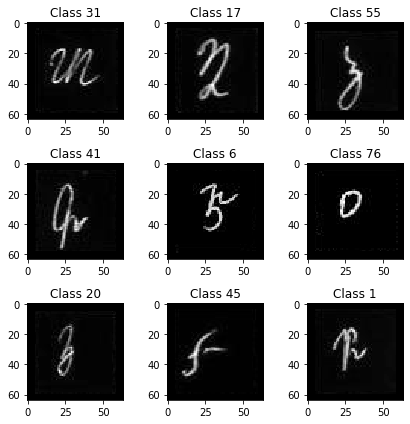

In [10]:
plt.rcParams['figure.figsize'] = (6,6) # Make the figures a bit bigger

for i in range(9):
  image = np.array(train[i]['image'].squeeze()) # get the image of the data sample
  label = train[i]['label'] # get the label of the data sample
  plt.subplot(3,3,i+1)
  plt.imshow(image, cmap='gray', interpolation='none')
  plt.title("Class {}".format(label))
    
plt.tight_layout()
print('The shape of our greyscale images: ', image.shape)

In [11]:
from networks.recognition_network import HandwrittingRecognitionNet

recognizer = HandwrittingRecognitionNet(**hparams).float()

In [12]:
summary(recognizer, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
           Dropout-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]         200,704
       BatchNorm2d-6           [-1, 64, 64, 64]             128
            Conv2d-7           [-1, 64, 64, 64]              64
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
          Dropout-10           [-1, 64, 64, 64]               0
         ResBlock-11           [-1, 64, 64, 64]               0
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
           Conv2d-13             [-1, 78, 1, 1]           5,070
          Flatten-14                   

In [13]:
classifier_logger = TensorBoardLogger(save_dir='lightning_logs', log_graph = True)
checkpoint_callback = ModelCheckpoint(
  monitor="val_loss",
  dirpath="models/",
  filename="mashtots-recognizer-{epoch:02d}-{val_loss:.2f}",
  save_top_k=3,
  mode="min",
)

trainer = pl.Trainer(
  overfit_batches=0.00013, # debug option
  track_grad_norm=2, # debug option
  default_root_dir=root_path,
  max_epochs=15,
  gpus=1 if torch.cuda.is_available() else None,
  check_val_every_n_epoch=10,
  logger=classifier_logger,
  callbacks=[EarlyStopping(monitor="val_loss"), checkpoint_callback]
)

trainer.fit(recognizer, DataModule)

/Users/edvardavagyan/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory models/ exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name              | Type             | Params | In sizes        | Out sizes
-------------------------------------------------------------------------------------
0 | feature_extractor | ModuleList       | 204 K  | ?               | ?        
1 | classifier        | Sequential       | 5.1 K  | [1, 64, 64, 64] | [1, 78]  
2 | loss_func         | CrossEntropyLoss | 0      | ?               | ?        
-------------------------------------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.837     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/edvardavagyan/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: You requested to overfit but enabled val/test dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)
/Users/edvardavagyan/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Avg-Loss=8.755276679992676


/Users/edvardavagyan/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)
/Users/edvardavagyan/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f89774d3310>
Traceback (most recent call last):
  File "/Users/edvardavagyan/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/Users/edvardavagyan/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.

In [14]:
recognizer.double()

HandwrittingRecognitionNet(
  (feature_extractor): ModuleList(
    (0): ResBlock(
      (skip): Sequential(
        (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResBlock(
      (skip): None
      (dropout): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3

In [100]:
torch.randn(3, 5, requires_grad=True).shape

torch.Size([3, 5])

In [16]:
# reload the model
pred_model = HandwrittingRecognitionNet.load_from_checkpoint('models/mashtots-recognizer-epoch=14-val_loss=1.76.ckpt')

In [21]:
pred_model.double()(train[0]['image'].unsqueeze(0).double())

tensor([[-4.7274, -4.1723, -5.0361, -4.6390, -4.7710, -5.2827, -4.9020, -5.1593,
         -4.7513,  3.9894, -4.3299, -4.6300, -5.0960,  3.4756, -4.7830, -5.0288,
         -4.0362, -4.6259, -5.3540, -4.6386, -4.8221, -5.1305, -4.7888, -5.4351,
         -4.4585,  4.1120, -5.0067, -4.7337, -4.2058, -5.1324, -4.4165, -4.9294,
         -4.9136, -5.2414, -4.4590, -5.0538,  4.1905, -4.1595, -4.8520, -4.6010,
          3.8529, -5.1095, -4.0811, -4.9802, -5.1927, -3.9967, -4.4575, -4.5199,
         -5.0903, -4.5155, -4.3142,  3.9463, -4.9273, -4.8867, -4.8901, -5.4893,
          3.8134, -4.8664, -4.2321, -4.8098, -4.7671, -5.2373, -5.2731, -4.2215,
         -4.8688, -4.3369, -4.2823, -5.1629, -4.1290, -4.7496, -4.8257, -5.6167,
         -4.9890, -4.7463,  3.3516, -4.4289, -5.1141, -4.1259]],
       dtype=torch.float64, grad_fn=<ViewBackward>)

In [22]:
trainer.predict(pred_model, DataModule.train_dataloader())

/Users/edvardavagyan/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: `train_dataloader` must be implemented to be used with the Lightning Trainer
  warnings.warn(*args, **kwargs)
/Users/edvardavagyan/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)


[]

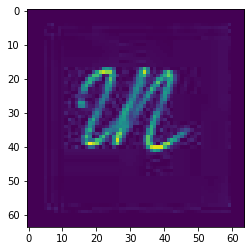

In [9]:
plt.imshow(train[0]['image'].squeeze(0))

In [10]:
train[0]['label']

31